In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi

import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
### test whole data with RNA only 
path = "/mnt/data0/halo/multivelo_BM/ATAC/multivelo_bonemarrow.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
# variables for subsetting the AnnData object to just the myeloid lineage


hsc_check = adata_mvi.obs['leiden'] == "HSC"
mpp_check = adata_mvi.obs['leiden'] == "MPP"
lmpp_check = adata_mvi.obs['leiden'] == "LMPP"
gmp_check = adata_mvi.obs['leiden'] == "GMP"

myeloid_check = (hsc_check | mpp_check | lmpp_check | gmp_check)
adata_mvi = adata_mvi[myeloid_check, :].copy()


In [4]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :15539
fine tune is False
gate decoder initialization n_input 10, n_output 175185,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [5]:
## load pre-trained models
# model = model.load("model_multivelo_fig5_nocausal", adata_mvi)
# model = model.load("model_multivelo_fig5_causal_0065_softmax", adata_mvi)
model = model.load("model_myeloid_data_nocausal", adata_mvi)

INFO     File model_myeloid_data_nocausal/model.pt already downloaded                        
n_genes :15539
fine tune is False
gate decoder initialization n_input 10, n_output 175185,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [5]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=800, batch_size=256)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 421/800:  52%|█████▎    | 420/800 [41:06<38:13,  6.03s/it, loss=2.62e+05, v_num=1]  

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
model.save("model_myeloid_data_nocausal",overwrite=True)

In [22]:
model.module.alpha = 0.066
model.module.beta_2 = 1e6
model.module.beta_3 = 1e8
model.module.beta_1 = 1e7
print(model.module.alpha)

0.066


In [23]:
## finetune without L0
model.module.alpha = 0.066
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=600, batch_size=256)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53/600:   9%|▊         | 52/600 [07:02<1:13:52,  8.09s/it, loss=2.93e+05, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [27]:
adata_mvi

AnnData object with n_obs × n_vars = 11605 × 190724
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'S_score', 'G2M_score', 'phase', 'fraction_u', 'leiden', 'root_prediction', 'total_s', 'total_u', 'total_Ms', 'total_Mu', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'modality', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden_colors'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

In [8]:
model.save("model_myeloid_data_causal066",overwrite=True)

In [19]:
model.save("model_multivelo_fig5_causal_0065_softmax", overwrite=True)

In [6]:
model = model.load("model_neural_BM_mouse_causal_0065_softmax",adata_mvi)

INFO     File model_neural_BM_mouse_causal_0065_softmax/model.pt already downloaded          
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [24]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [34]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import infer_nonsta_dir


latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score3 = []
score4=[]

cells = latent_expr.shape[0]
locals = 1500
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:,:], latent_expr_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:,:], latent_atac_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:(i+1)*locals,:], latent_expr_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:(i+1)*locals,:], latent_atac_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())

# for i in range(iterations):
#         choices = np.random.choice(cells, locals)
#         score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[choices,:], latent_expr_indep_t[choices:], times[choices])[0].detach().cpu())
#         score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[choices,:], latent_atac_indep_t[choices,:], times[choices])[0].detach().cpu())

print("score3 {} and score4 {}".format(score3, score4))

score3 = np.mean(np.array(score3))
score4 = np.mean(np.array(score4))


# score3, _, _ = infer_nonsta_dir(latent_atac_indep[:5000,:], latent_expr_indep[:5000, :], times[:5000])
# score3
# score4, _, _ = infer_nonsta_dir(latent_expr_indep[:5000,:], latent_atac_indep[:5000,:], times[:5000])
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

/tmp/ipykernel_4382/550197123.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(times).to('cuda')


score3 [tensor(0.0672, dtype=torch.float64), tensor(0.0667, dtype=torch.float64), tensor(0.0658, dtype=torch.float64), tensor(0.0677, dtype=torch.float64)] and score4 [tensor(0.0684, dtype=torch.float64), tensor(0.0678, dtype=torch.float64), tensor(0.0670, dtype=torch.float64), tensor(0.0689, dtype=torch.float64)]
score3 0.06683311728242558 and score4 0.06802853108959653


-0.0011954138071709475

In [35]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import infer_nonsta_dir


latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
# times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score1 = []
score2=[]

cells = latent_expr.shape[0]
locals = 1000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:,:], latent_expr_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:,:], latent_atac_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:(i+1)*locals,:], latent_expr_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:(i+1)*locals,:], latent_atac_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())


score1 = np.mean(np.array(score1))
score2 = np.mean(np.array(score2))


# score3, _, _ = infer_nonsta_dir(latent_atac_indep[:5000,:], latent_expr_indep[:5000, :], times[:5000])
# score3
# score4, _, _ = infer_nonsta_dir(latent_expr_indep[:5000,:], latent_atac_indep[:5000,:], times[:5000])
print("score1 {} and score2 {}".format(score1, score2))


score1 0.07594340513978999 and score2 0.06691961828095351


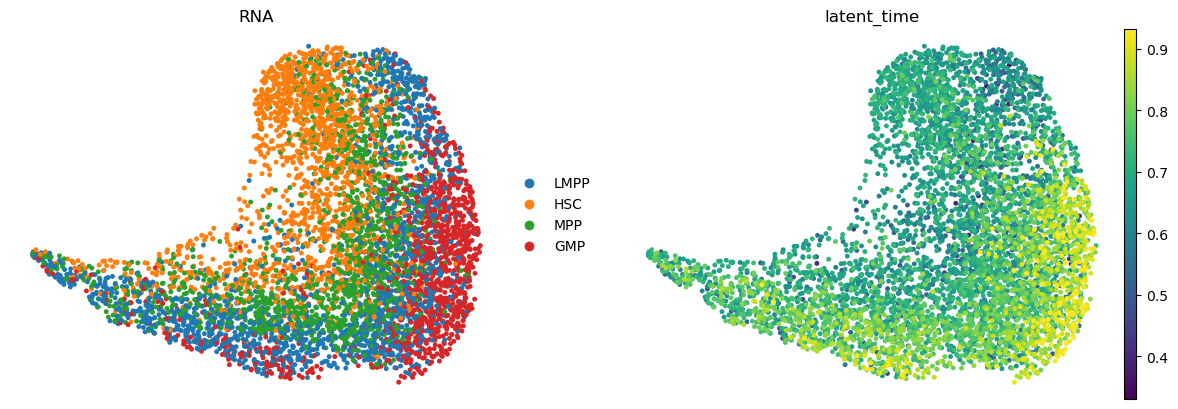

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


adata_mvi.obsm["latent"] = latent_expr 
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)
sc.tl.umap(adata_mvi,min_dist =0.5)

sc.pl.umap(adata_mvi, color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
# sc.pl.scatter(adata_mvi,color='leiden',basis='umap', s=50, title = 'RNA')
plt.show()

Epoch 10/600:   2%|▏         | 9/600 [12:03<13:12:21, 80.44s/it, loss=2.72e+05, v_num=1]


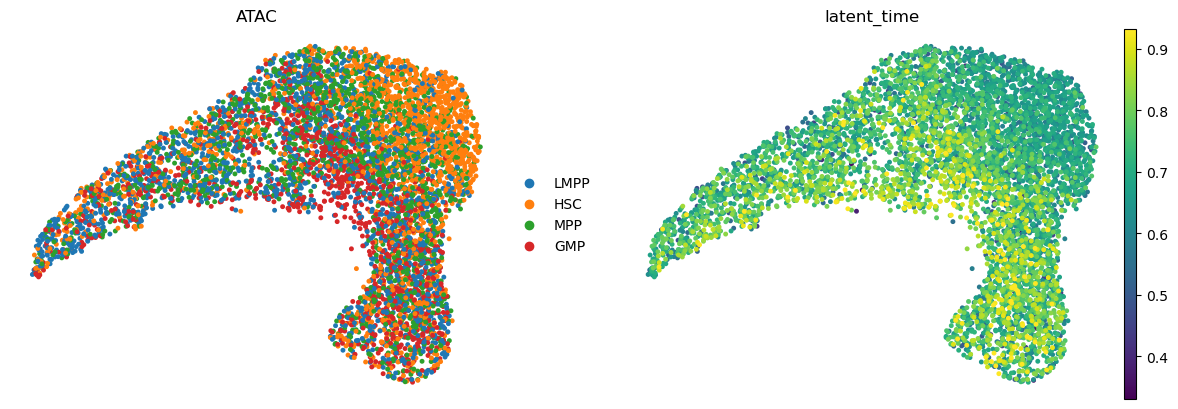

In [28]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

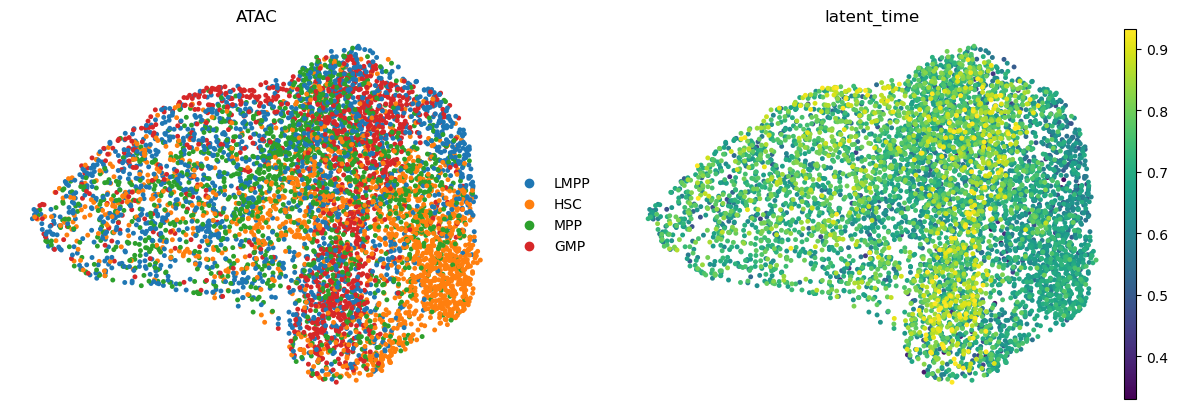

In [29]:
adata_mvi.obsm["latent"] = latent_acc + latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

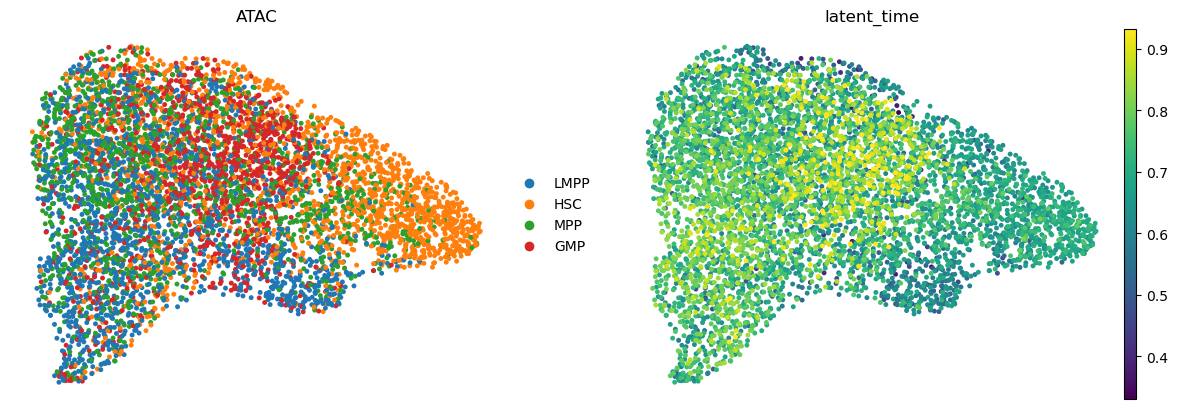

In [37]:
adata_mvi.obsm["latent"] =latent_expr_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

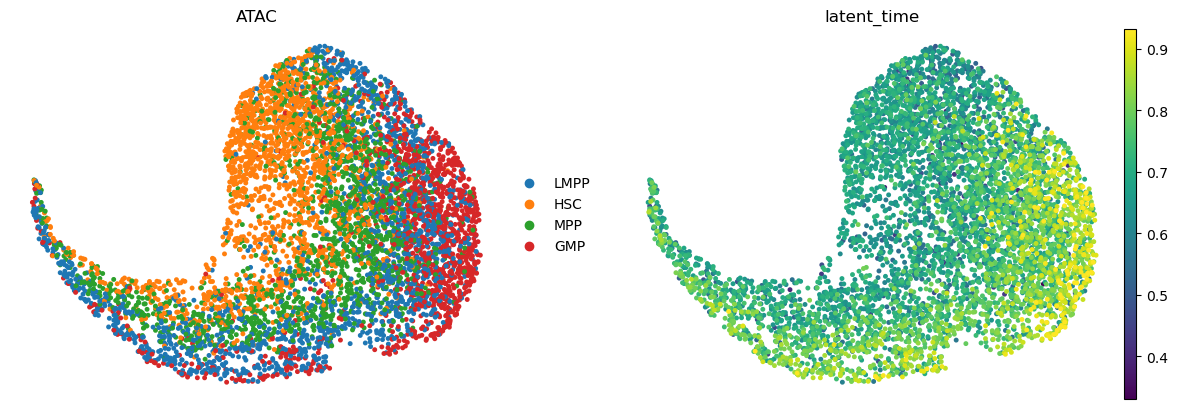

In [38]:
adata_mvi.obsm["latent"] =latent_expr_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

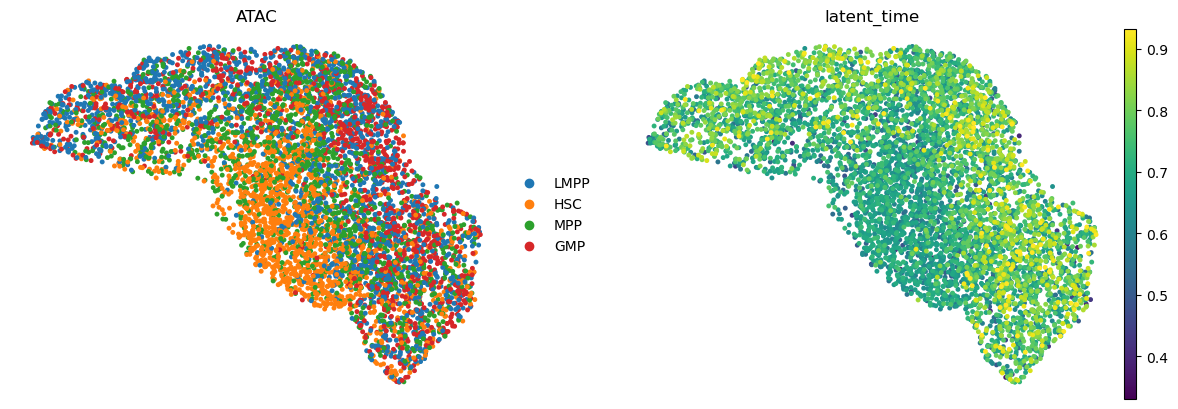

In [39]:
adata_mvi.obsm["latent"] =latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()

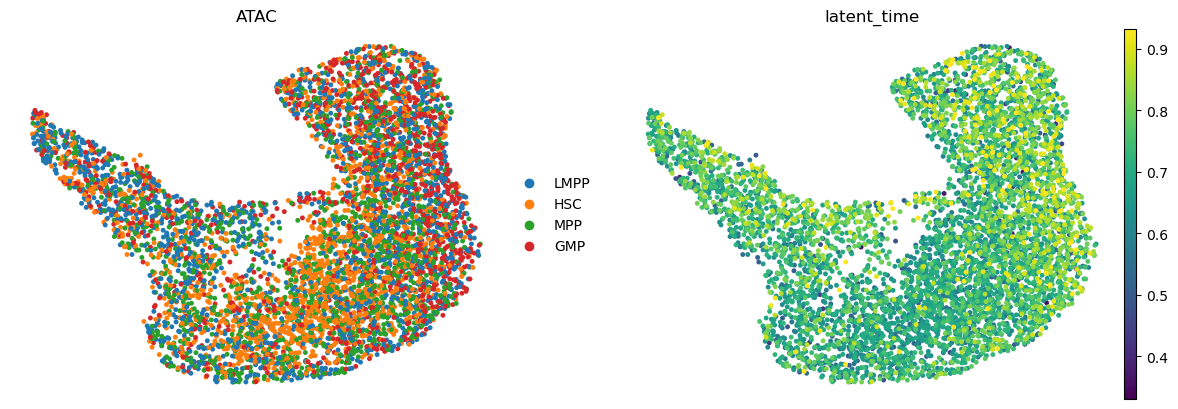

In [40]:
adata_mvi.obsm["latent"] =latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC")

plt.show()